In [6]:
import os
import json
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from torch.utils.data import Dataset, DataLoader

In [7]:
def interleaved_to_complex(source_data):
    """
    Convert interleaved IQ data to complex numbers
    """
    source_data = np.array(source_data)
    source_data = source_data / 32768
    source_data = source_data.astype(np.float32).view(np.complex64)
    return source_data


def iq_to_psd(iq_data, num_fft, sample_rate):
    """
    # Compute the PSD of the input IQ data
    """
    freq, psd = signal.welch(
        iq_data, fs=sample_rate, nperseg=num_fft, return_onesided=False
    )
    return psd


def read_labels(file_path):
    """
    Reads a CSV file with two columns (x, y) and returns a dictionary with x as the key and y as the value
    """
    labels = {}
    with open(file_path, "r") as f:
        for line in f:
            label = line.strip().split(",")
            label[0] = int(label[0])
            labels[label[0]] = {"wifi": 0, "bluetooth": 1}.get(label[1], -1)
    return labels


def read_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

class psd_dataset(Dataset):
    def __init__(self, data_directory, labels):
        self.labels = read_labels(labels)
        self.data_directory = data_directory

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data_path = os.path.join(self.data_directory, f"data_{idx}.npy")
        data = torch.from_numpy(np.load(data_path))
        label = self.labels[idx]
        return data, label

In [8]:
training_dataset = psd_dataset(
    "./data/training_data_psd", "./data/training_data_psd/labels.csv"
)
testing_dataset = psd_dataset(
    "./data/testing_data_psd", "./data/testing_data_psd/labels.csv"
)
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=16)
testing_dataloader = DataLoader(testing_dataset, batch_size=8, shuffle=True, num_workers=16)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


Epoch 1
-------------------------------
loss: 0.696760  [    0/  285]
Epoch 2
-------------------------------
loss: 0.315723  [    0/  285]
Epoch 3
-------------------------------
loss: 0.071987  [    0/  285]
Epoch 4
-------------------------------
loss: 0.002489  [    0/  285]
Epoch 5
-------------------------------
loss: 0.000258  [    0/  285]
Done!
Saved PyTorch Model State to model.pth


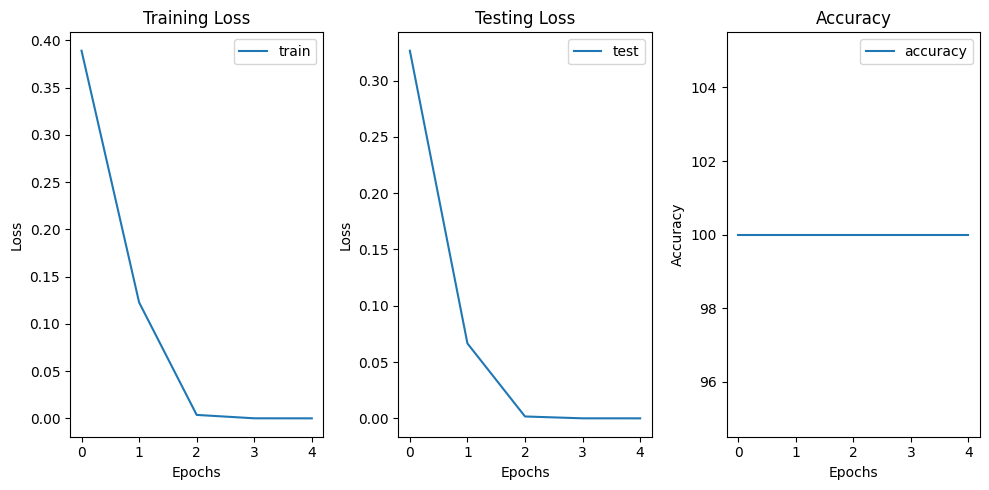

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (sample, label) in enumerate(dataloader):
        sample, label = sample.to(device), label.to(device)

        pred = model(sample)
        loss = loss_fn(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(sample)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss.cpu().detach().numpy()

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample, label in dataloader:
            sample, label = sample.to(device), label.to(device)
            pred = model(sample)
            test_loss += loss_fn(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct = (correct / size) * 100

    return test_loss, correct


epochs = 5
train_losses = []
test_losses = []
accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(training_dataloader, model, loss_fn, optimizer)
    test_loss, correct = test(testing_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(correct)

print("Done!")
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="train")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_losses, label="test")
plt.title("Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(accuracies, label="accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()
